<a href="https://colab.research.google.com/github/KarelZe/thesis/blob/baseline/notebooks/3.0-mb-feature_engineering_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost==1.1
!pip install gcsfs==2022.10.0
!pip install ipywidgets==8.0.2
!pip install numpy==1.23.4
!pip install pandas==1.5.1
!pip install fastparquet
!pip install optuna==3.0.3
!pip install scikit-learn==1.1.3
!pip install seaborn==0.12.1
!pip install wandb==0.13.4


In [ ]:
import os
import random

from catboost import CatBoostClassifier, Pool

import gcsfs

# import google.auth
# from google.colab import auth, output

import numpy as np
import pandas as pd
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import seaborn as sns

from tqdm.notebook import tqdm
import wandb


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
import google.auth
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/root/.config/gcloud/application_default_credentials.json"

# credentials, _ = google.auth.default()
# fs = gcsfs.GCSFileSystem(project="thesis", token=credentials)

fs = gcsfs.GCSFileSystem(project="thesis")
fs_prefix = "gs://"

/usr/lib/python3/dist-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/.
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [ ]:
# set fixed seed
def seed_everything(seed):
    """
    Seeds basic parameters for reproducibility of results
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)


seed = 42
seed_everything(seed)


In [ ]:
train = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_60.parquet",
    engine="fastparquet",
)
val = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_20.parquet",
    engine="fastparquet",
)
test = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_20.parquet",
    engine="fastparquet",
)


In [ ]:
train.head(10)


,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
0,BRCD,2005-05-02 09:30:02,72515,YNU,2006-01-21,2.5,C,10,2.05,1.90,...,1.90,131.0,20.0,1.90,1.90,21060388.0,10.0,1.90,2.10,1
1,SYMC,2005-05-02 09:30:03,65366,SYQ,2005-06-18,15.0,C,10,3.90,3.60,...,NaN,NaN,NaN,4.00,4.00,31624184.0,10.0,4.60,4.00,1
2,SPY,2005-05-02 09:30:03,65373,SWG,2005-05-21,105.0,C,50,11.20,11.10,...,11.10,300.0,300.0,11.80,11.00,31620976.0,50.0,11.90,11.00,-1
3,ADRX,2005-05-02 09:30:03,79195,QAX,2005-06-18,25.0,C,10,0.20,0.00,...,0.00,0.0,86.0,0.15,0.15,31560072.0,10.0,0.15,0.15,1
4,ORCL,2005-05-02 09:30:03,95870,ORQ,2005-12-17,14.0,C,15,0.25,0.30,...,0.25,3356.0,399.0,0.35,0.35,25240212.0,17.0,0.35,0.35,-1
5,YHOO,2005-05-02 09:30:03,73595,YHQ,2005-10-22,35.0,P,26,3.00,2.95,...,2.90,1133.0,256.0,3.10,3.40,24020608.0,46.0,3.10,3.40,-1
6,MATK,2005-05-02 09:30:03,80182,KQT,2005-09-17,65.0,C,2,0.55,0.30,...,0.30,56.0,10.0,0.45,0.45,23989792.0,2.0,0.65,0.45,1
7,VTSS,2005-05-02 09:30:04,80469,VQT,2005-10-22,5.0,P,10,2.75,2.70,...,2.70,10.0,52.0,2.90,2.90,24019950.0,40.0,2.90,2.90,-1
8,ADRX,2005-05-02 09:30:04,80342,QAX,2005-09-17,25.0,C,1,0.60,0.45,...,0.45,94.0,25.0,0.55,0.50,23983374.0,11.0,0.65,0.50,1
9,IVGN,2005-05-02 09:30:04,97063,IUV,2005-08-20,65.0,C,10,11.00,0.00,...,NaN,NaN,NaN,13.80,9.90,23797976.0,10.0,13.80,9.90,1


In [ ]:
# randomly sample frac of rows
# frac = 0.02

# train = train.sample(frac=frac, random_state=seed)
# val = val.sample(frac=frac, random_state=seed)
# test = test.sample(frac=frac, random_state=seed)

# unify for common preprocessing
X = pd.concat([train, val, test])


In [ ]:
# isolate target
y = X[["buy_sell"]]
X = X.drop(["buy_sell"], axis=1)


In [ ]:
# calculate days to maturity
X["time_to_maturity"] = (X["EXPIRATION"] - X["QUOTE_DATETIME"]).dt.days


In [ ]:
# apply positional encoding to dates
X["date_month_sin"] = np.sin(2 * np.pi * X["QUOTE_DATETIME"].dt.year / 12)
X["date_month_cos"] = np.cos(2 * np.pi * X["QUOTE_DATETIME"].dt.year / 12)

# apply positional encoding to dates
X["date_month_sin"] = np.sin(2 * np.pi * X["QUOTE_DATETIME"].dt.year / 12)
X["date_month_cos"] = np.cos(2 * np.pi * X["QUOTE_DATETIME"].dt.year / 12)

seconds_in_day = 24 * 60 * 60

seconds = (X["QUOTE_DATETIME"] - X["QUOTE_DATETIME"].dt.normalize()).dt.total_seconds()

X["date_time_sin"] = np.sin(2 * np.pi * seconds / seconds_in_day)
X["date_time_cos"] = np.cos(2 * np.pi * seconds / seconds_in_day)

# add year
X["date_year"] = (X["QUOTE_DATETIME"].dt.year - 2005) / (2017 - 2005)

date_columns = [
    "date_month_sin",
    "date_month_cos",
    "date_time_sin",
    "date_time_cos",
    "date_year",
]


In [ ]:
feature_set_date = [
    "date_month_sin",
    "date_month_cos",
    "date_time_sin",
    "date_time_cos" "date_year",
]
feature_set_option = [
    "STRK_PRC",
    "ROOT",
    "price_underlying",
    "time_to_maturity",
    "moneyness",
    "delta",
    "option-type",
    "security_type",
]

# features of classical rules
feature_set_1 = [
    "TRADE_PRICE",
    "price_ex_lag",
    "chg_ex_lag",
    "price_ex_lead",
    "chg_ex_lead",
    "bid_ex",
    "ask_ex",
    "midpoint_ex",
    "rel_mid_ex",
    "rel_bid_dist_ex",
    "rel_ask_dist_ext",
]

# features of classical rules enhanced for date features
feature_set_2 = [*feature_set_1, *feature_set_date]

# features of classical rules enhanced for date features and option features
feature_set_4 = [*feature_set_1, *feature_set_date, *feature_set_option]

# FIXME: adjust as needed
feature_sets = [feature_set_1, feature_set_2]
ignored_features = [x for x in X.columns.tolist() if x not in feature_set_2]
X.drop(columns=ignored_features, inplace=True)


In [ ]:
# Calculate change similar to tick rule
X["chg_ex_lead"] = X["TRADE_PRICE"] - X["price_ex_lead"]

# Calculate change similar to reverse tick rule
X["chg_ex_lag"] = X["TRADE_PRICE"] - X["price_ex_lag"]

# Midspread
mid = 0.5 * (X["ask_ex"] + X["bid_ex"])
X["midpoint_ex"] = mid

# distance metrics
X["rel_mid_ex"] = (X["TRADE_PRICE"] - mid) / (X["ask_ex"] - mid)
X["rel_bid_dist_ex"] = (X["TRADE_PRICE"] - X["bid_ex"]) / (mid - X["bid_ex"])
X["rel_ask_dist_ex"] = (X["ask_ex"] - X["TRADE_PRICE"]) / (X["ask_ex"] - mid)


In [ ]:
# log transform
log_columns = [
    "TRADE_PRICE",
    "price_ex_lag",
    "price_ex_lead",
    "bid_ex",
    "ask_ex",
    "midpoint_ex",
]

X[log_columns] = np.log(X[log_columns] + 1e-5)


In [ ]:
# binarize

# select categorical e. g., option type and strings e. g., ticker
cat_columns = X.select_dtypes(include=["category", "object"]).columns.tolist()
print(cat_columns)

# binarize categorical similar to Borisov et al.
X[cat_columns] = X[cat_columns].apply(lambda x: pd.factorize(x)[0])


[]


In [ ]:
# treat inf as nan
X.replace([np.inf, -np.inf], np.nan, inplace=True)


In [ ]:
# separate again for training scaling
X_train = X.loc[train.index, :]
X_val = X.loc[val.index, :]
X_test = X.loc[test.index, :]

y_train = y.loc[train.index, :]
y_val = y.loc[val.index, :]
y_test = y.loc[test.index, :]


In [ ]:
# Standardize numerical values, if not standardized otherwise
num_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
num_columns = [
    x for x in num_columns if x not in [*cat_columns, *date_columns, *log_columns]
]
# use scaler due to outlying observations > dataset notebook.
scaler = StandardScaler()

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_val[num_columns] = scaler.transform(X_val[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])


## CatBoost Baseline 🐈‍⬛

### Hyperparameter Search Baseline🗃️

In [ ]:
def objective(trial: optuna.Trial, features: list, cat_features: list = None):
    # See docs for recommendations on tuning hyperparameters
    #  https://catboost.ai/en/docs/concepts/parameter-tuning

    ignored_features = [x for x in X_train.columns.tolist() if x not in features]

    iterations = trial.suggest_int("iterations", 100, 1500, log=False)
    learning_rate = trial.suggest_float("learning_rate", 0.005, 1, log=True)
    depth = trial.suggest_int("depth", 1, 8, log=False)
    grow_policy = trial.suggest_categorical(
        "grow_policy", ["SymmetricTree", "Depthwise"]
    )
    params = {
        "iterations": iterations,
        "depth": depth,
        "grow_policy": grow_policy,
        "learning_rate": learning_rate,
        "od_type": "Iter",
        "logging_level": "Silent",
        "task_type": "GPU",
        "cat_features": cat_features,
        "ignored_features": ignored_features,
    }

    model = CatBoostClassifier(**params)

    model.fit(
        X_train,
        y_train,
    )

    y_pred = model.predict(X_val, prediction_type="Class")
    return accuracy_score(y_val, y_pred)


In [ ]:
studies = []

for features in tqdm(feature_sets):

    # FIXME: Change later if needed
    cat_features = None

    # connect to weights and biases
    run = wandb.init(project="thesis", job_type="baseline", entity="fbv")

    wandb_kwargs = {"project": "thesis"}
    wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)

    # Implement hyperparameter search
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=seed),
        study_name="baseline_gbm",
    )

    study.optimize(
        lambda trial: objective(trial, features, cat_features),
        n_trials=25,
        callbacks=[wandbc],
    )
    studies.append(study)

    # fit classifier using best parameter combination
    trial = study.best_trial
    static_params = {"od_type": "Iter", "task_type": "GPU", "cat_features": cat_columns}
    params = {**static_params, **trial.params}
    print(params)

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, plot=True, verbose=False)

    # plot accuracy for train, val and test
    acc_train = model.score(X_train, y_train)
    acc_val = model.score(X_val, y_val)
    acc_test = model.score(X_test, y_test)

    print(f"Accuracy (train): {acc_train}, (val) {acc_val}, and (test) {acc_test}")

    run.finish()


  0%|          | 0/2 [00:00<?, ?it/s]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-20-ad03fda8721d>:12: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)


[I 2022-11-12 13:26:51,591] A new study created in memory with name: baseline_gbm
/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
[I 2022-11-12 13:27:54,125] Trial 0 finished with value: 0.6178872116756041 and parameters: {'iterations': 624, 'learning_rate': 0.7701798297509621, 'depth': 6, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.6178872116756041.
/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
[I 2022-11-12 13:28:35,502] Trial 1 finished with value: 0.60666257045596 and parameters: {'iterations': 318, 'l

{'od_type': 'Iter', 'task_type': 'GPU', 'cat_features': [], 'iterations': 823, 'learning_rate': 0.2704966733913418, 'depth': 8, 'grow_policy': 'Depthwise'}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin


Accuracy (train): 0.7762152697768103, (val) 0.6126783247630584, and (test) 0.5902354755467077


<ipython-input-20-ad03fda8721d>:12: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)


[I 2022-11-12 13:58:04,508] A new study created in memory with name: baseline_gbm
/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
[I 2022-11-12 13:59:07,088] Trial 0 finished with value: 0.6112391247589086 and parameters: {'iterations': 624, 'learning_rate': 0.7701798297509621, 'depth': 6, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.6112391247589086.
/usr/local/lib/python3.8/dist-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
[I 2022-11-12 13:59:49,467] Trial 1 finished with value: 0.5973822223302611 and parameters: {'iterations': 318, 

{'od_type': 'Iter', 'task_type': 'GPU', 'cat_features': [], 'iterations': 1340, 'learning_rate': 0.12216952524150139, 'depth': 8, 'grow_policy': 'Depthwise'}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy (train): 0.7751827157414762, (val) 0.6133232694433632, and (test) 0.5917529814707102


  0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-21-e122d82789ba>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax_history = optuna.visualization.matplotlib.plot_optimization_history(study)
<ipython-input-21-e122d82789ba>:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  ax_param_importance = optuna.visualization.matplotlib.plot_param_importances(study)
<ipython-input-21-e122d82789ba>:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig_contour = optuna.visualization.matplotlib.plot_contour(
[W 2022-11-12 14:37:06,740] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
<ipython-input-21-e122d82789ba>:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can 

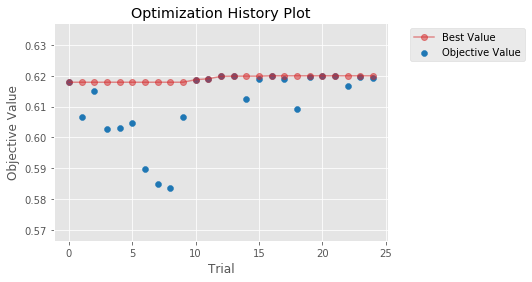

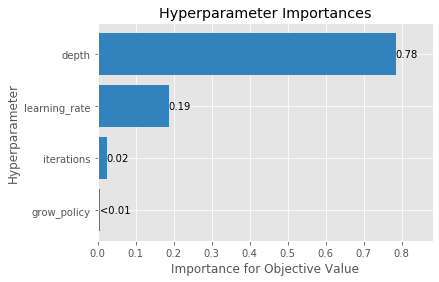

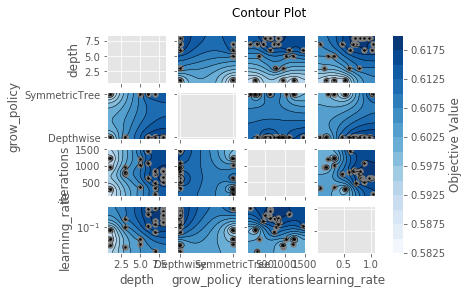

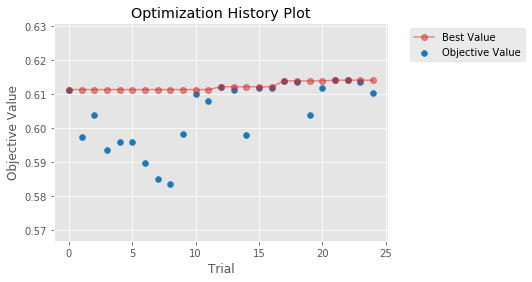

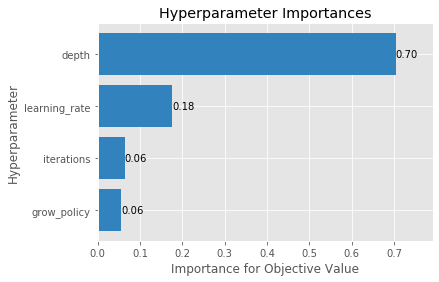

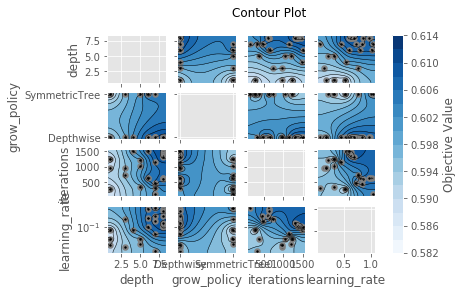

In [ ]:
for study in tqdm(studies):
    ax_history = optuna.visualization.matplotlib.plot_optimization_history(study)
    ax_param_importance = optuna.visualization.matplotlib.plot_param_importances(study)
    fig_contour = optuna.visualization.matplotlib.plot_contour(
        study, ["iterations", "depth", "grow_policy", "learning_rate"]
    )


### Robustness Baseline🥊

In [ ]:
# Copy unscaled columns
X_print = test.copy()
# X_print = pd.concat([train, val, test])

# add baseline results
X_print["rule"] = "Baseline"
X_print["buy_sell_predicted"] = 0  # model.predict(X_test)

# prepare columns for printing
X_print["ttm"] = (
    X_print["EXPIRATION"].dt.to_period("M")
    - X_print["QUOTE_DATETIME"].dt.to_period("M")
).apply(lambda x: x.n)
X_print["year"] = X_print["QUOTE_DATETIME"].dt.year

bins_tradesize = [-np.inf, 1, 3, 5, 11, np.inf]
trade_size_labels = ["(0,1]", "(1,3]", "(3,5]", "(5,11]", ">11"]
X_print["TRADE_SIZE_binned"] = pd.cut(
    X_print["TRADE_SIZE"], bins_tradesize, labels=trade_size_labels
)

bins_years = [2004, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
year_labels = [
    "2005-2007",
    "2008-2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
]
X_print["year_binned"] = pd.cut(X_print["year"], bins_years, labels=year_labels)

bins_ttm = [-np.inf, 1, 2, 3, 6, 12, np.inf]
ttm_labels = [
    "ttm <= 1 month",
    "ttm (1-2] month",
    "ttm (2-3] month",
    "ttm (3-6] month",
    "ttm (6-12] month",
    "ttm > 12 month",
]
X_print["ttm_binned"] = pd.cut(X_print["ttm"], bins_ttm, labels=ttm_labels)

# TODO: Security type
# TODO: Moneyness
# TODO: time from previous trade; same underlying or any?


In [ ]:
def check_robustness(criterion: str = "year_binned") -> pd.DataFrame:
    """
    Check robustness of rules by calculating the accuracy for a given
    criterion and rules.

    Example:
    rule		Baseline
    TRADE_SIZE_binned
    (0,1]	  0.710966
    (1,3]	  0.717664
    (3,5]	  0.715195
    (5,11]	0.699428
    >11	  	0.688348

    Args:
        criterion (str, optional): criterion to check robustness for.
        Defaults to "year_binned".

    Returns:
        pd.DataFrame: DataFrame with accuracy of rules. Rule in columns and
        criterion values in rows.
    """

    # fill others randomly with equal weight for every class.
    X_print["buy_sell_predicted"] = X_print["buy_sell_predicted"].map(
        lambda l: l if not np.isnan(l) else np.random.choice([-1, 1])
    )

    # cuculate average over columns if multiple subsets are combined
    results = (
        X_print.groupby(["rule", criterion])[["buy_sell", "buy_sell_predicted"]]
        .apply(lambda x: accuracy_score(x["buy_sell"], x["buy_sell_predicted"]))
        .unstack(level=0)
        .assign(avg=lambda x: x.mean(axis=1))
    )
    return results


In [ ]:
check_robustness("year_binned")


rule,Baseline,avg
year_binned,,
2015,0.0,0.0
2016,0.0,0.0
2017,0.0,0.0


In [ ]:
check_robustness("OPTION_TYPE")


rule,Baseline,avg
OPTION_TYPE,,
C,0.0,0.0
P,0.0,0.0


In [ ]:
check_robustness("TRADE_SIZE_binned")


rule,Baseline,avg
TRADE_SIZE_binned,,
"(0,1]",0.0,0.0
"(1,3]",0.0,0.0
"(3,5]",0.0,0.0
"(5,11]",0.0,0.0
>11,0.0,0.0


In [ ]:
check_robustness("ttm_binned")


rule,Baseline,avg
ttm_binned,,
ttm <= 1 month,0.0,0.0
ttm (1-2] month,0.0,0.0
ttm (2-3] month,0.0,0.0
ttm (3-6] month,0.0,0.0
ttm (6-12] month,0.0,0.0
ttm > 12 month,0.0,0.0
